# 3 qubit bit flip code

## Phase and bit flip channel

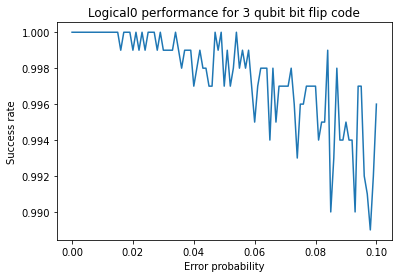

In [18]:
import matplotlib.pyplot as plt
from qiskit_aer.noise import pauli_error
from qiskit import *
error_probabilities = []
success_rates = []
for error_probability in range(0,101,1):    
    error_probability = error_probability / 1000.0
    error_probabilities.append(error_probability)
    # Create a quantum register with 5 qubits
    q = QuantumRegister(5)
    
    # Create a classical register with 5 bits
    c = ClassicalRegister(2)
    
    # Create a quantum circuit
    bit_flip = QuantumCircuit(q, c)
    
    # Prepares qubit in the desired initial state 
    
    # Encodes the qubit in a three-qubit entangled state  
    bit_flip.cx(q[0], q[1])
    bit_flip.cx(q[0], q[2])
    
    # Construct a 1-qubit bit-flip error
    p_error = error_probability
    error = pauli_error([('X', p_error/2),('Z', p_error/2), ('I', 1 - p_error)])
    
    
    # Combine the circuit and the error channel
    for i in range(0,3):
        bit_flip.append(error, [i])
    
    # Adds additional two qubits for error-correction
    bit_flip.cx(q[0], q[3])
    bit_flip.cx(q[1], q[3])
    bit_flip.cx(q[1], q[4])
    bit_flip.cx(q[2], q[4])
    
    # Measure the two additional qubits
    bit_flip.measure(q[3], c[0])
    bit_flip.measure(q[4], c[1])
    
    # Do error correction
    bit_flip.x(q[0]).c_if(c,1)
    bit_flip.x(q[1]).c_if(c,3)
    bit_flip.x(q[2]).c_if(c,2)
    
    # Decodes the qubit from the three-qubit entangled state  
    # bit_flip.cx(q[0], q[1])
    # bit_flip.cx(q[0], q[2])
    
    # Create a classical register with 3 bits
    cr = ClassicalRegister(3)
                
    # Add the classical register to the quantum circuit
    bit_flip.add_register(cr)
    # Check the state of the initial qubit
    for i in range(0,3):
        bit_flip.measure(q[i], cr[i])
    # Choose a simulator
    simulator = Aer.get_backend('qasm_simulator')
    
    # Execute the circuit on the simulator
    result = execute(bit_flip, simulator, shots = 1000).result()
    
    # Get the counts from the result
    counts = result.get_counts()
    
    num_successes = 0
    counts_dict = dict(counts)
    for key, value in counts_dict.items():
        if key[:3] == '000':
            num_successes += value
    #print(error_probability,num_successes)
    success_rate = num_successes / 1000.0
    success_rates.append(success_rate)
    
#Plot the success rate as a function of the error probability
plt.plot(error_probabilities, success_rates)
plt.title('Logical0 performance for 3 qubit bit flip code')
plt.xlabel('Error probability')
plt.ylabel('Success rate')
plt.show()

This code simulates a quantum error correction circuit to correct bit-flip errors on a single qubit. It performs error correction at increasing error probabilities, starting from 0% and increasing by 0.1% at each iteration up to 10%. For each error probability, the code performs 1000 rounds of error correction. 

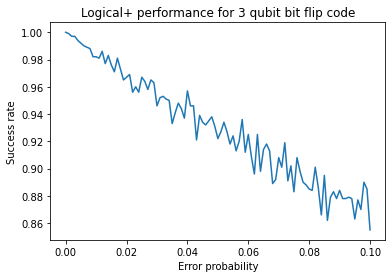

In [19]:
error_probabilities = []
success_rates = []
for error_probability in range(0,101,1):    
    error_probability = error_probability / 1000.0
    error_probabilities.append(error_probability)
    # Create a quantum register with 5 qubits
    q = QuantumRegister(5)
    
    # Create a classical register with 5 bits
    c = ClassicalRegister(2)
    
    # Create a quantum circuit
    bit_flip = QuantumCircuit(q, c)
    
    # Prepares qubit in the desired initial state 
    
    # Encodes the qubit in a three-qubit entangled state  
    bit_flip.h(0)
    bit_flip.cx(q[0], q[1])
    bit_flip.cx(q[0], q[2])
    
    # Construct a 1-qubit bit-flip error
    p_error = error_probability
    error = pauli_error([('X', p_error/2), ('Z', p_error/2), ('I', 1 - p_error)])
    
    
    # Combine the circuit and the error channel
    for i in range(0,3):
        bit_flip.append(error, [i])
    
    # Adds additional two qubits for error-correction
    bit_flip.cx(q[0], q[3])
    bit_flip.cx(q[1], q[3])
    bit_flip.cx(q[1], q[4])
    bit_flip.cx(q[2], q[4])
    
    # Measure the two additional qubits
    bit_flip.measure(q[3], c[0])
    bit_flip.measure(q[4], c[1])
    
    # Do error correction
    bit_flip.x(q[0]).c_if(c,1)
    bit_flip.x(q[1]).c_if(c,3)
    bit_flip.x(q[2]).c_if(c,2)
    
    # Decodes the qubit from the three-qubit entangled state  
    bit_flip.cx(q[0], q[1])
    bit_flip.cx(q[0], q[2])
    bit_flip.h(q[0])
    
    # Create a classical register with 3 bits
    cr = ClassicalRegister(3)
                
    # Add the classical register to the quantum circuit
    bit_flip.add_register(cr)
    # Check the state of the initial qubit
    for i in range(0,3):
        bit_flip.measure(q[i], cr[i])
    # Choose a simulator
    simulator = Aer.get_backend('qasm_simulator')
    
    # Execute the circuit on the simulator
    result = execute(bit_flip, simulator, shots = 1000).result()
    
    # Get the counts from the result
    counts = result.get_counts()
    
    num_successes = 0
    counts_dict = dict(counts)
    for key, value in counts_dict.items():
        if key[:3] == '000':
            num_successes += value
    #print(error_probability,num_successes)
    success_rate = num_successes / 1000.0
    success_rates.append(success_rate)
    
#Plot the success rate as a function of the error probability
plt.plot(error_probabilities, success_rates)
plt.title('Logical+ performance for 3 qubit bit flip code')
plt.xlabel('Error probability')
plt.ylabel('Success rate')
plt.show()

# 3 Qubit Phase flip code

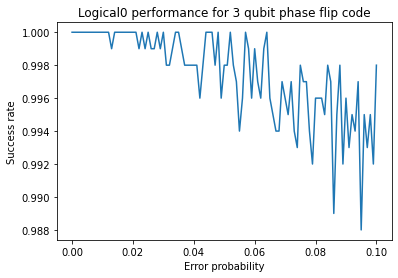

In [21]:
error_probabilities = []
success_rates = []
for error_probability in range(0,101,1):    
    error_probability = error_probability / 1000.0
    error_probabilities.append(error_probability)
    # Create a quantum register with 5 qubits
    q = QuantumRegister(5)
    
    # Create a classical register with 5 bits
    c = ClassicalRegister(2)
    
    # Create a quantum circuit
    phase_flip = QuantumCircuit(q, c)
    
    # Prepares qubit in the desired initial state 
    
    # Encodes the qubit in a three-qubit entangled state  
    phase_flip.cx(q[0], q[1])
    phase_flip.cx(q[0], q[2])
    for i in range(0,3):
        phase_flip.h(q[i])
    
    # Construct a 1-qubit bit-flip error
    p_error = error_probability
    error = pauli_error([('X', p_error/2),('Z', p_error/2), ('I', 1 - p_error)])
    
    
    # Combine the circuit and the error channel
    for i in range(0,3):
        phase_flip.append(error, [i])
    for i in range(0,3):
        phase_flip.h(q[i])
    # Adds additional two qubits for error-correction
    phase_flip.cx(q[0], q[3])
    phase_flip.cx(q[1], q[3])
    phase_flip.cx(q[1], q[4])
    phase_flip.cx(q[2], q[4])
    
    # Measure the two additional qubits
    phase_flip.measure(q[3], c[0])
    phase_flip.measure(q[4], c[1])
    
    # Do error correction
    phase_flip.x(q[0]).c_if(c,1)
    phase_flip.x(q[1]).c_if(c,3)
    phase_flip.x(q[2]).c_if(c,2)
    
    # Decodes the qubit from the three-qubit entangled state  
    phase_flip.cx(q[0], q[1])
    phase_flip.cx(q[0], q[2])
    
    # Create a classical register with 3 bits
    cr = ClassicalRegister(3)
                
    # Add the classical register to the quantum circuit
    phase_flip.add_register(cr)
    # Check the state of the initial qubit
    for i in range(0,3):
        phase_flip.measure(q[i], cr[i])
    # Choose a simulator
    simulator = Aer.get_backend('qasm_simulator')
    
    # Execute the circuit on the simulator
    result = execute(phase_flip, simulator, shots = 1000).result()
    
    # Get the counts from the result
    counts = result.get_counts()
    
    num_successes = 0
    counts_dict = dict(counts)
    for key, value in counts_dict.items():
        if key[:3] == '000':
            num_successes += value
#     print(error_probability, num_successes)
    success_rate = num_successes / 1000.0
    success_rates.append(success_rate)
    
#Plot the success rate as a function of the error probability
plt.plot(error_probabilities, success_rates)
plt.title('Logical0 performance for 3 qubit phase flip code')
plt.xlabel('Error probability')
plt.ylabel('Success rate')
plt.show()

This code simulates a quantum error correction circuit to correct phase-flip errors on a single qubit. It performs error correction at increasing error probabilities, starting from 0% and increasing by 0.1% at each iteration up to 10%. For each error probability, the code performs 1000 rounds of error correction. 

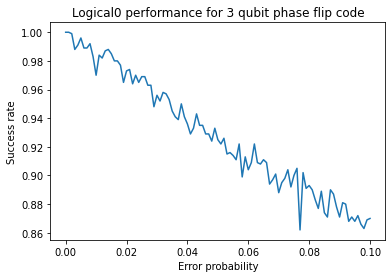

In [23]:
error_probabilities = []
success_rates = []
for error_probability in range(0,101,1):    
    error_probability = error_probability / 1000.0
    error_probabilities.append(error_probability)
    # Create a quantum register with 5 qubits
    q = QuantumRegister(5)
    
    # Create a classical register with 5 bits
    c = ClassicalRegister(2)
    
    # Create a quantum circuit
    phase_flip = QuantumCircuit(q, c)
    
    # Prepares qubit in the desired initial state 
    
    # Encodes the qubit in a three-qubit entangled state  
    phase_flip.h(q[0])
    phase_flip.cx(q[0], q[1])
    phase_flip.cx(q[0], q[2])
    for i in range(0,3):
        phase_flip.h(q[i])
    
    # Construct a 1-qubit bit-flip error
    p_error = error_probability
    error = pauli_error([('X', p_error/2),('Z', p_error/2), ('I', 1 - p_error)])
    
    
    # Combine the circuit and the error channel
    for i in range(0,3):
        phase_flip.append(error, [i])
    for i in range(0,3):
        phase_flip.h(q[i])
    # Adds additional two qubits for error-correction
    phase_flip.cx(q[0], q[3])
    phase_flip.cx(q[1], q[3])
    phase_flip.cx(q[1], q[4])
    phase_flip.cx(q[2], q[4])
    
    # Measure the two additional qubits
    phase_flip.measure(q[3], c[0])
    phase_flip.measure(q[4], c[1])
    
    # Do error correction
    phase_flip.x(q[0]).c_if(c,1)
    phase_flip.x(q[1]).c_if(c,3)
    phase_flip.x(q[2]).c_if(c,2)
    
    # Decodes the qubit from the three-qubit entangled state  
    phase_flip.cx(q[0], q[1])
    phase_flip.cx(q[0], q[2])
    phase_flip.h(q[0])
    # Create a classical register with 3 bits
    cr = ClassicalRegister(3)
                
    # Add the classical register to the quantum circuit
    phase_flip.add_register(cr)
    # Check the state of the initial qubit
    for i in range(0,3):
        phase_flip.measure(q[i], cr[i])
    # Choose a simulator
    simulator = Aer.get_backend('qasm_simulator')
    
    # Execute the circuit on the simulator
    result = execute(phase_flip, simulator, shots = 1000).result()
    
    # Get the counts from the result
    counts = result.get_counts()
    
    num_successes = 0
    counts_dict = dict(counts)
    for key, value in counts_dict.items():
        if key[:3] == '000':
            num_successes += value
#     print(error_probability,num_successes)
    success_rate = num_successes / 1000.0
    success_rates.append(success_rate)
    
#Plot the success rate as a function of the error probability
plt.plot(error_probabilities, success_rates)
plt.title('Logical0 performance for 3 qubit phase flip code')
plt.xlabel('Error probability')
plt.ylabel('Success rate')
plt.show()

# Shor Code

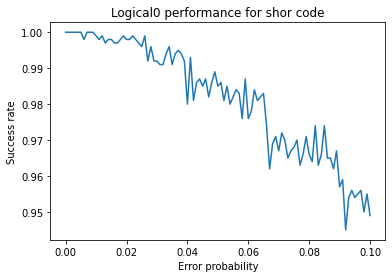

In [25]:
error_probabilities = []
success_rates = []
for error_probability in range(0,101,1):    
    error_probability = error_probability / 1000.0
    error_probabilities.append(error_probability)
    # Create a quantum register with 9 code qubits and 8 ancilla qubits
    q = QuantumRegister(17)

    # Create a classical register with 6 bits
    c = ClassicalRegister(2)

    # Create a quantum circuit
    shor = QuantumCircuit(q, c)

    # Encodes the qubit in a nine-qubit entangled state  
    shor.cx(q[0], q[3])
    shor.cx(q[0], q[6])
    shor.h(q[0])
    shor.h(q[3])
    shor.h(q[6])

    for i in range(1,3):
        shor.cx(0,i)
    for j in range(4,6):
        shor.cx(3,j)
    for k in range(7,9):
        shor.cx(6,k)

    # Construct a 1-qubit error-flip error
    p_error = error_probability
    error = pauli_error([('X', p_error/2), ('Z', p_error/2),('I', 1 - p_error)])


    # Combine the circuit and the error channel
    for i in range(0,9):
        shor.append(error, [i])

    #Entangle with bit flip ancilla qubits
    #First block
    shor.cx(q[0],q[9])
    shor.cx(q[1],q[9])
    shor.cx(q[1],q[10])
    shor.cx(q[2],q[10])
    # Measure the two additional qubits
    shor.measure(q[9], c[0])
    shor.measure(q[10], c[1])

    # Do error correction
    shor.x(q[0]).c_if(c,1)
    shor.x(q[1]).c_if(c,3)
    shor.x(q[2]).c_if(c,2)

    #Add another 2 classical bits for the next block
    # Create a classical register with 2 bits
    c1 = ClassicalRegister(2)

    # Add the classical register to the quantum circuit
    shor.add_register(c1)
    #Second block
    shor.cx(q[3],q[11])
    shor.cx(q[4],q[11])
    shor.cx(q[4],q[12])
    shor.cx(q[5],q[12])
    # Measure the two additional qubits
    shor.measure(q[11], c1[0])
    shor.measure(q[12], c1[1])

    # Do error correction
    shor.x(q[3]).c_if(c1,1)
    shor.x(q[4]).c_if(c1,3)
    shor.x(q[5]).c_if(c1,2)

    # Add another creg
    c2 = ClassicalRegister(2)
    # Add the classical register to the quantum circuit
    shor.add_register(c2)
    #Third block
    shor.cx(q[6],q[13])
    shor.cx(q[7],q[13])
    shor.cx(q[7],q[14])
    shor.cx(q[8],q[14])

    # Measure the two additional qubits
    shor.measure(q[13], c2[0])
    shor.measure(q[14], c2[1])

    # Do error correction
    shor.x(q[6]).c_if(c2,1)
    shor.x(q[7]).c_if(c2,3)
    shor.x(q[8]).c_if(c2,2)

    shor.barrier()
    # Add another creg
    c3 = ClassicalRegister(2)
    # Add the classical register to the quantum circuit
    shor.add_register(c3)
    #phase flip syndrome measurements
    for i in range(9):
        shor.h(q[i])
    #Entangle with ancillas
    for i in range(6):
        shor.cx(q[i],q[15])
    for i in range(3,9):
        shor.cx(q[i],q[16])

    # Measure the two additional qubits
    shor.measure(q[15], c3[0])
    shor.measure(q[16], c3[1])

    #Back into x basis
    for i in range(9):
        shor.h(q[i])
    # Do error correction
    shor.z(q[0]).c_if(c3,1)
    shor.z(q[3]).c_if(c3,3)
    shor.z(q[6]).c_if(c3,2)

    shor.barrier()
    #Decode
    for i in range(1,3):
        shor.cx(q[0],q[i])
    for j in range(4,6):
        shor.cx(q[3],q[j])
    for k in range(7,9):
        shor.cx(q[6],q[k])
    shor.h(q[0])
    shor.h(q[3])
    shor.h(q[6])
    shor.cx(q[0],q[3])
    shor.cx(q[0],q[6])

    #Now measure the code qubits to see if the error was corrected successfully
    # Add another creg
    c4 = ClassicalRegister(9)
    # Add the classical register to the quantum circuit
    shor.add_register(c4)
    for i in range(9):
        shor.measure(q[i],c4[i])

    # Choose a simulator
    simulator = Aer.get_backend('qasm_simulator')

    # Execute the circuit on the simulator
    result = execute(shor, simulator, shots = 1000).result()

    # Get the counts from the result
    counts = result.get_counts()
    num_successes = 0
    counts_dict = dict(counts)
    for key, value in counts_dict.items():
        if key[:9] == '000000000':
            num_successes += value
    #print(error_probability,num_successes)
    success_rate = num_successes / 1000.0
    success_rates.append(success_rate)
    
#Plot the success rate as a function of the error probability
plt.plot(error_probabilities, success_rates)
plt.title('Logical0 performance for shor code')
plt.xlabel('Error probability')
plt.ylabel('Success rate')
plt.show()

This code simulates a quantum error correction circuit to correct phase-flip and bit-flip errors on a single qubit. It performs error correction at increasing error probabilities, starting from 0% and increasing by 0.1% at each iteration up to 10%. For each error probability, the code performs 1000 rounds of error correction. 

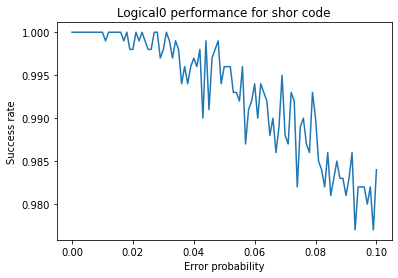

In [27]:
error_probabilities = []
success_rates = []
for error_probability in range(0,101,1):    
    error_probability = error_probability / 1000.0
    error_probabilities.append(error_probability)
    # Create a quantum register with 9 code qubits and 8 ancilla qubits
    q = QuantumRegister(17)

    # Create a classical register with 6 bits
    c = ClassicalRegister(2)

    # Create a quantum circuit
    shor = QuantumCircuit(q, c)

    # Encodes the qubit in a nine-qubit entangled state  
    shor.h(q[0])
    shor.cx(q[0], q[3])
    shor.cx(q[0], q[6])
    shor.h(q[0])
    shor.h(q[3])
    shor.h(q[6])

    for i in range(1,3):
        shor.cx(0,i)
    for j in range(4,6):
        shor.cx(3,j)
    for k in range(7,9):
        shor.cx(6,k)

    # Construct a 1-qubit error-flip error
    p_error = error_probability
    error = pauli_error([('X', p_error/2), ('Z', p_error/2),('I', 1 - p_error)])


    # Combine the circuit and the error channel
    for i in range(0,9):
        shor.append(error, [i])

    #Entangle with bit flip ancilla qubits
    #First block
    shor.cx(q[0],q[9])
    shor.cx(q[1],q[9])
    shor.cx(q[1],q[10])
    shor.cx(q[2],q[10])
    # Measure the two additional qubits
    shor.measure(q[9], c[0])
    shor.measure(q[10], c[1])

    # Do error correction
    shor.x(q[0]).c_if(c,1)
    shor.x(q[1]).c_if(c,3)
    shor.x(q[2]).c_if(c,2)

    #Add another 2 classical bits for the next block
    # Create a classical register with 2 bits
    c1 = ClassicalRegister(2)

    # Add the classical register to the quantum circuit
    shor.add_register(c1)
    #Second block
    shor.cx(q[3],q[11])
    shor.cx(q[4],q[11])
    shor.cx(q[4],q[12])
    shor.cx(q[5],q[12])
    # Measure the two additional qubits
    shor.measure(q[11], c1[0])
    shor.measure(q[12], c1[1])

    # Do error correction
    shor.x(q[3]).c_if(c1,1)
    shor.x(q[4]).c_if(c1,3)
    shor.x(q[5]).c_if(c1,2)

    # Add another creg
    c2 = ClassicalRegister(2)
    # Add the classical register to the quantum circuit
    shor.add_register(c2)
    #Third block
    shor.cx(q[6],q[13])
    shor.cx(q[7],q[13])
    shor.cx(q[7],q[14])
    shor.cx(q[8],q[14])

    # Measure the two additional qubits
    shor.measure(q[13], c2[0])
    shor.measure(q[14], c2[1])

    # Do error correction
    shor.x(q[6]).c_if(c2,1)
    shor.x(q[7]).c_if(c2,3)
    shor.x(q[8]).c_if(c2,2)

    shor.barrier()
    # Add another creg
    c3 = ClassicalRegister(2)
    # Add the classical register to the quantum circuit
    shor.add_register(c3)
    #phase flip syndrome measurements
    for i in range(9):
        shor.h(q[i])
    #Entangle with ancillas
    for i in range(6):
        shor.cx(q[i],q[15])
    for i in range(3,9):
        shor.cx(q[i],q[16])

    # Measure the two additional qubits
    shor.measure(q[15], c3[0])
    shor.measure(q[16], c3[1])

    #Back into x basis
    for i in range(9):
        shor.h(q[i])
    # Do error correction
    shor.z(q[0]).c_if(c3,1)
    shor.z(q[3]).c_if(c3,3)
    shor.z(q[6]).c_if(c3,2)

    shor.barrier()
    #Decode
    for i in range(1,3):
        shor.cx(q[0],q[i])
    for j in range(4,6):
        shor.cx(q[3],q[j])
    for k in range(7,9):
        shor.cx(q[6],q[k])
    shor.h(q[0])
    shor.h(q[3])
    shor.h(q[6])
    shor.cx(q[0],q[3])
    shor.cx(q[0],q[6])
    shor.h(q[0])
    #Now measure the code qubits to see if the error was corrected successfully
    # Add another creg
    c4 = ClassicalRegister(9)
    # Add the classical register to the quantum circuit
    shor.add_register(c4)
    for i in range(9):
        shor.measure(q[i],c4[i])

    # Choose a simulator
    simulator = Aer.get_backend('qasm_simulator')

    # Execute the circuit on the simulator
    result = execute(shor, simulator, shots = 1000).result()

    # Get the counts from the result
    counts = result.get_counts()
    num_successes = 0
    counts_dict = dict(counts)
    for key, value in counts_dict.items():
        if key[:9] == '000000000':
            num_successes += value
    #print(error_probability,num_successes)
    success_rate = num_successes / 1000.0
    success_rates.append(success_rate)
    
#Plot the success rate as a function of the error probability
plt.plot(error_probabilities, success_rates)
plt.title('Logical0 performance for shor code')
plt.xlabel('Error probability')
plt.ylabel('Success rate')
plt.show()